In [1]:
import pandas as pd
import numpy as np
import itertools as it
import os
import io
import logging

import boto3
import sys
import json
import snowflake.connector

# Reading Data 

In [2]:
input_bucket = "hbo-ingest-datascience-content-dev"

In [4]:
logger = logging.getLogger()
logger.info(f'Loading inputs')
data_list =[]

s3 = boto3.resource('s3')
bucket = s3.Bucket(input_bucket)

for obj in bucket.objects.filter(Prefix='cost_allocation/dev/churn_metric_0811'):
            key = obj.key
            logger.info('Loading csv file {}'.format(key))
            body = obj.get()['Body']
            print('Reading {0} features'.format(key))
            churn_metric = pd.read_csv(body, na_values = [r'\\\\N'])

Reading cost_allocation/dev/churn_metric_0906.csv features


In [5]:
churn_metric.head()

Unnamed: 0   genre     medal category  churn_per_hr_person
0           0  action  Platinum   movies            -0.028358
1           1  action      Gold   series            -0.020530
2           2  action      Gold   movies            -0.027117
3           3  action    Silver   series            -0.005406
4           4  action    Silver   movies            -0.019190

In [6]:
from abc import ABCMeta, abstractmethod

class Credentials(metaclass=ABCMeta):
    pass
    
    
class SSMPSCredentials(Credentials):
    def __init__(self, secretid: str):
        self._secretid = secretid
        self._secrets = {}
        
    def get_keys(self):
        """
        credential fetching 
        """
        _aws_sm_args = {'service_name': 'secretsmanager', 'region_name': 'us-east-1'}
        secrets_client = boto3.client(**_aws_sm_args)
        get_secret_value_response = secrets_client.get_secret_value(SecretId=self._secretid)
        return get_secret_value_response
    
    
class BaseConnector(metaclass=ABCMeta):
    @abstractmethod
    def connect(self):
        raise NotImplementedError
    

class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )

        return ctx
    
## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
ctx=conn.connect("MAX_DEV","WORKSPACE")

def run_query(query):
    cursor = ctx.cursor()
    cursor.execute(query)
    df = pd.DataFrame(cursor.fetchall(), columns = [desc[0] for desc in cursor.description])
    df.columns= df.columns.str.lower()
    return df

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [7]:
# hours_viewed = run_query('''SELECT * FROM max_dev.workspace.user_title_hours_watched_crossvalidation''')

In [16]:
hours_viewed = pd.read_csv('validation_data.csv')

In [18]:
hours_viewed.head()

Unnamed: 0                              title_name               title_id  \
0           0     VICE Special Report: Killing Cancer  GV-54_wnG7qbCwwEAAAAY   
1           1  VICE Special Report: Countdown to Zero  GV-55HghKlqbCwwEAAAAb   
2           2  VICE Special Report: Fixing the System  GV-55Hwvj4IaDwwEAAAAY   
3           3      VICE Special Report: Fighting ISIS  GV-55JASHjruwgwEAAAAU   
4           4                           Heartbreakers  GV-BGJA11hsLDwwEAAAAZ   

   season_number  days_on_hbo_max  cumulative_hours_viewed  \
0              0               60                64.627222   
1              0               60                32.569444   
2              0               60               139.329722   
3              0               60               163.436389   
4              0               60             11945.052500   

   average_hours_viewed offering_start_date  asset_run_time_hours  \
0              0.000049          2020-05-27              0.640000   
1              0.000025          2020-05-27              0.809722   
2              0.000106          2020-05-27              1.108055   
3              0.000124          2020-05-27              0.786388   
4              0.003908          2020-09-01              2.057777   

  content_category  ... genre_Kids/Family.2 genre_Music.2 genre_Other.2  \
0           movies  ...                   0             0             0   
1           movies  ...                   0             0             0   
2           movies  ...                   0             0             0   
3           movies  ...                   0             0             0   
4           movies  ...                   0             0             0   

   genre_Romance.2 genre_Sci-Fi.2  genre_Suspense/Thriller.2  \
0                0              0                          0   
1                0              0                          0   
2                0              0                          0   
3                0              0                          0   
4                0              0                          0   

   genre_Unscripted.2          hvr      ahvr  content_cost  
0                   0   100.980035  0.000077           NaN  
1                   0    40.222996  0.000031           NaN  
2                   0   125.742605  0.000095           NaN  
3                   0   207.831743  0.000158           NaN  
4                   0  5804.833323  0.001899      259000.0  

[5 rows x 84 columns]

In [19]:
hours_viewed = hours_viewed[['title_name', 'title_id', 'season_number', 'offering_start_date' , 'ahvr', 'pillar_genre', 'medal']]

In [20]:
hours_viewed.rename(columns = {'ahvr':'average_hours_viewed_60d', 'pillar_genre': 'genre'}, inplace = True)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [11]:
hours_viewed.loc[hours_viewed['genre'] == 'Action/Adventure ', 'genre'] = 'action'
hours_viewed.loc[hours_viewed['genre'] == 'Comedy', 'genre'] = 'comedy'
hours_viewed.loc[hours_viewed['genre'] == 'Drama', 'genre'] = 'drama'
hours_viewed.loc[~hours_viewed['genre'].isin(['action', 'comedy', 'drama']), 'genre'] = 'other'

hours_viewed.loc[hours_viewed['medal'] == 'None', 'medal'] = 'Bronze'

In [12]:
hours_viewed = hours_viewed.merge(churn_metric[['genre','medal','churn_per_hr_person']], on = ['genre','medal'], how = 'left')

In [13]:
hours_viewed['change_in_churn_60d'] = hours_viewed['average_hours_viewed_60d'] * hours_viewed['churn_per_hr_person']

In [14]:
hours_viewed_thresh = hours_viewed[hours_viewed['average_hours_viewed_60d'] >= 0 ]

# Allocate the 60-Day Churn to monthly

## First 60 Allocation

In [14]:
dt_df = pd.DataFrame()
dt_df['days_on_hbo_max'] = [i for i in range(0, 60, 1)]

In [15]:
hours_viewed_thresh['key'] = 1
dt_df['key'] = 1

In [16]:
hours_viewed_60d = hours_viewed_thresh.merge(dt_df, on = ['key']).drop(['key'], axis = 1)

hours_viewed_60d['request_date'] = pd.to_datetime(hours_viewed_60d['offering_start_date']) \
                                    + pd.to_timedelta(hours_viewed_60d['days_on_hbo_max'], unit='D')

hours_viewed_60d['change_in_churn'] = hours_viewed_60d['change_in_churn_60d']/60

## After 60 Day Allocation

In [17]:
ever_green_titles = pd.read_csv('ever_green_titles.csv')

In [18]:
ever_green_titles.head()

Unnamed: 0            title_name               title_id  season_number  \
0        5892             Injustice  GYbvoqgoeYawYwwEAAAAN              0   
1        5249                 Red 2  GYOjdCwdKNsI-wgEAAAZc              0   
2        3698                Misery  GXrHsBAPxLomBSgEAAAB4              0   
3        3296        Ella Enchanted  GXoTAXgmV2ZCtwwEAAACI              0   
4        3198  The Hangover Part II  GXnjwZgr15aFYqQEAAAbj              0   

                match_id offering_start_date      ahvr   ahvr_90  
0  GYbvoqgoeYawYwwEAAAAN          2022-01-17  0.236977  0.593506  
1  GYOjdCwdKNsI-wgEAAAZc          2022-02-01  0.027843  0.052037  
2  GXrHsBAPxLomBSgEAAAB4          2020-06-01  0.018080  0.027320  
3  GXoTAXgmV2ZCtwwEAAACI          2020-05-27  0.017993  0.026021  
4  GXnjwZgr15aFYqQEAAAbj          2020-05-27  0.029151  0.045031

In [19]:
len(ever_green_titles.title_id.unique())

62

In [20]:
len(hours_viewed_thresh.title_id.unique())

6145

In [21]:
ever_green_titles.sort_values(by = ['title_name']).title_name.unique()

array(['2 Fast 2 Furious', 'Along Came Polly', 'American Pie',
       'American Psycho', 'Annabelle Comes Home', 'Bad Education',
       'Batman: Assault on Arkham', 'Batman: Under the Red Hood',
       'Big Little Lies', 'Contraband', 'Cowboys & Aliens',
       'Curb Your Enthusiasm', 'Downton Abbey',
       "Dr. Seuss' How the Grinch Stole Christmas", 'Ella Enchanted',
       'Euphoria', 'Fight Club', 'Friday After Next', 'Friends',
       'Full Metal Jacket', 'G.I. Joe: The Rise of Cobra',
       'Game of Thrones', 'Godzilla: King of the Monsters', 'Good Boys',
       'Hall Pass', 'How to Lose a Guy in 10 Days',
       'Ice Age: Continental Drift', 'Injustice',
       'Justice League Dark: Apokolips War',
       'Justice League vs the Fatal Five',
       'Justice League vs. Teen Titans',
       'Justice League: Crisis on Two Earths', 'Justice League: Doom',
       'Justice League: Gods and Monsters',
       'Justice League: The Flashpoint Paradox',
       'Justice League: Throne of 

In [22]:
ever_green_title_id = ever_green_titles.title_id.unique()

In [23]:
norm_title_id = hours_viewed_thresh[~hours_viewed_thresh['title_id'].isin(ever_green_title_id)].title_id.unique()

### 1. Normal Titles

In [24]:
from scipy.optimize import curve_fit

In [25]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

Matplotlib is building the font cache; this may take a moment.


In [26]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

## 90% of the retention value deteriorates in the first year
x = [0, 0.8, 5]
y = [1, 0.1, 0.0001]

popt, pcov = curve_fit(func, x, y)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [27]:
x1 = pd.Series(np.arange(0,5,0.1))
y1 = func(x1, *popt)

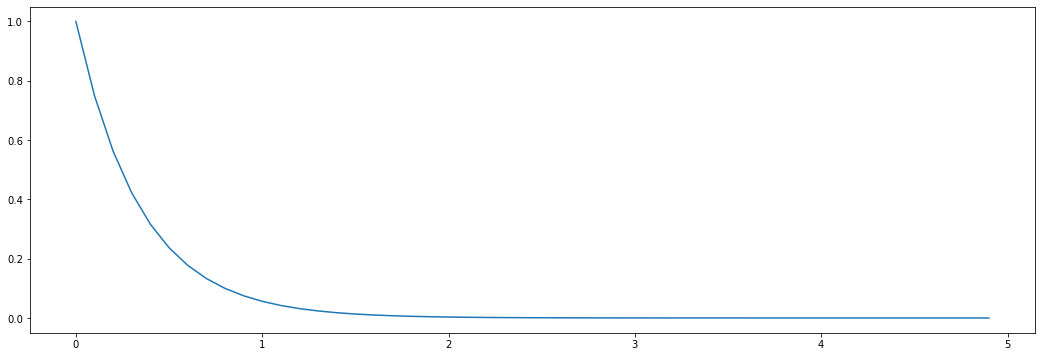

In [28]:
fig, ax = plt.subplots(figsize=(18, 6))
plt.plot(x1, y1)
plt.show()

In [29]:
dt_df = pd.DataFrame()
dt_df['days_on_hbo_max'] = [i for i in range(0, 365, 1)]
dt_df['factor'] = func(dt_df['days_on_hbo_max']/365, *popt)
dt_df['key'] = 1

In [30]:
hours_viewed_decay_norm = hours_viewed_thresh[hours_viewed_thresh['title_id'].isin(norm_title_id)]

hours_viewed_decay_norm = hours_viewed_decay_norm.merge(dt_df, on = ['key']).drop(['key'], axis = 1)

hours_viewed_decay_norm['change_in_churn'] = hours_viewed_decay_norm['change_in_churn_60d']/60*hours_viewed_decay_norm['factor']

hours_viewed_decay_norm['days_on_hbo_max'] = hours_viewed_decay_norm['days_on_hbo_max']+60

hours_viewed_decay_norm['request_date'] = pd.to_datetime(hours_viewed_decay_norm['offering_start_date']) \
                                        + pd.to_timedelta(hours_viewed_decay_norm['days_on_hbo_max'], unit='D')

hours_viewed_decay_norm = hours_viewed_decay_norm[hours_viewed_decay_norm['request_date'] <= '2023-03-01']


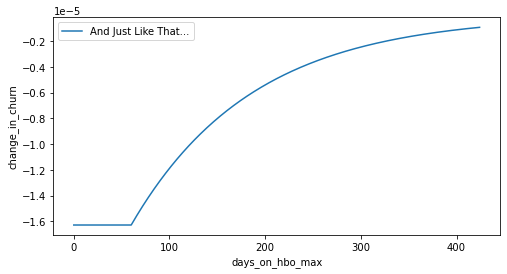

In [31]:
fig, ax = plt.subplots(figsize=(8, 4))
test = pd.concat([hours_viewed_60d[['title_name', 'title_id', 'season_number', 'request_date', 'days_on_hbo_max', 'change_in_churn']],
                hours_viewed_decay_norm[['title_name', 'title_id', 'season_number', 'request_date', 'days_on_hbo_max','change_in_churn']]],
                axis = 0)
plot_df = test[test['title_name'] == 'And Just Like That...']
plt.plot(plot_df['days_on_hbo_max'], plot_df['change_in_churn'], label='And Just Like That...')

ax.set_xlabel('days_on_hbo_max')
ax.set_ylabel('change_in_churn')
ax.legend()

plt.show()

### 2. Evergreen Titles

#### 2.1 Sogmoid Decay

In [32]:
# ## 90% of the retention value is deteriorated in the first year
# x = [0, 0.25, 1.5, 3]
# y = [1, 0.99, 0.5, 0.001]

# def sigmoid(x, L ,x0, k, b):
#     y = L / (1 + np.exp(-k*(x-x0))) + b
#     return (y)

# p0 = [max(y), np.median(x),1,min(y)] # this is an mandatory initial guess

# popt, pcov = curve_fit(sigmoid, x, y ,p0, method='dogbox')

# x1 = pd.Series(np.arange(0,5,0.1))
# y1 = sigmoid(x1, *popt)

# fig, ax = plt.subplots(figsize=(18, 6))
# plt.plot(x1, y1)
# plt.show()

In [33]:
# dt_df = pd.DataFrame()
# dt_df['days_on_hbo_max'] = [i for i in range(0, 365*3, 1)]
# dt_df['factor'] = sigmoid(dt_df['days_on_hbo_max']/365, *popt)
# dt_df['key'] = 1

# hours_viewed_decay_evergreen = hours_viewed_thresh[hours_viewed_thresh['title_id'].isin(ever_green_title_id)]

# hours_viewed_decay_evergreen = hours_viewed_decay_evergreen.merge(dt_df, on = ['key']).drop(['key'], axis = 1)

# hours_viewed_decay_evergreen['change_in_churn'] = hours_viewed_decay_evergreen['change_in_churn_60d']/60*hours_viewed_decay_evergreen['factor']

# hours_viewed_decay_evergreen['days_on_hbo_max'] = hours_viewed_decay_evergreen['days_on_hbo_max']+60

# hours_viewed_decay_evergreen['request_date'] = pd.to_datetime(hours_viewed_decay_evergreen['offering_start_date']) \
#                                         + pd.to_timedelta(hours_viewed_decay_evergreen['days_on_hbo_max'], unit='D')

# hours_viewed_decay_evergreen = hours_viewed_decay_evergreen[hours_viewed_decay_evergreen['request_date'] <= '2023-03-01']


In [34]:
# fig, ax = plt.subplots(figsize=(8, 4))
# test = pd.concat([hours_viewed_60d[['title_name', 'title_id', 'season_number', 'request_date', 'days_on_hbo_max', 'change_in_churn']],
#                 hours_viewed_decay_evergreen[['title_name', 'title_id', 'season_number', 'request_date', 'days_on_hbo_max', 'change_in_churn']]],
#                 axis = 0)


# for i in range(1, 11, 1):
#     plot_df = test[(test['title_name'] == 'Friends') &(test['season_number'] == i)]
#     plt.plot(plot_df['days_on_hbo_max'], plot_df['change_in_churn'], label= 'Friends S' + str(i))

# ax.set_xlabel('days_on_hbo_max')
# ax.set_ylabel('change_in_churn')
# ax.legend()

# plt.show()

#### 2.2 Keep the retention value all the way along

In [35]:
dt_df = pd.DataFrame()
dt_df['days_on_hbo_max'] = [i for i in range(0, 365*3, 1)]
dt_df['key'] = 1

hours_viewed_decay_evergreen = hours_viewed_thresh[hours_viewed_thresh['title_id'].isin(ever_green_title_id)]

hours_viewed_decay_evergreen = hours_viewed_decay_evergreen.merge(dt_df, on = ['key']).drop(['key'], axis = 1)

hours_viewed_decay_evergreen['change_in_churn'] = hours_viewed_decay_evergreen['change_in_churn_60d']/60

hours_viewed_decay_evergreen['days_on_hbo_max'] = hours_viewed_decay_evergreen['days_on_hbo_max']+60

hours_viewed_decay_evergreen['request_date'] = pd.to_datetime(hours_viewed_decay_evergreen['offering_start_date']) \
                                        + pd.to_timedelta(hours_viewed_decay_evergreen['days_on_hbo_max'], unit='D')

hours_viewed_decay_evergreen = hours_viewed_decay_evergreen[hours_viewed_decay_evergreen['request_date'] <= '2023-03-01']


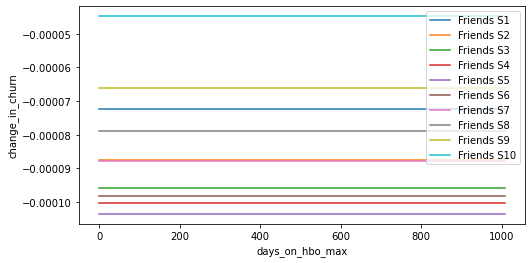

In [36]:
fig, ax = plt.subplots(figsize=(8, 4))
test = pd.concat([hours_viewed_60d[['title_name', 'title_id', 'season_number', 'request_date', 'days_on_hbo_max', 'change_in_churn']],
                hours_viewed_decay_evergreen[['title_name', 'title_id', 'season_number', 'request_date', 'days_on_hbo_max', 'change_in_churn']]],
                axis = 0)


for i in range(1, 11, 1):
    plot_df = test[(test['title_name'] == 'Friends') &(test['season_number'] == i)]
    plt.plot(plot_df['days_on_hbo_max'], plot_df['change_in_churn'], label= 'Friends S' + str(i))

ax.set_xlabel('days_on_hbo_max')
ax.set_ylabel('change_in_churn')
ax.legend()

plt.show()

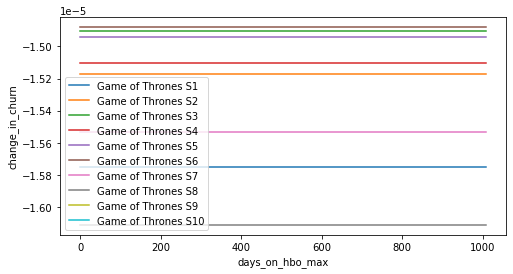

In [37]:
fig, ax = plt.subplots(figsize=(8, 4))
test = pd.concat([hours_viewed_60d[['title_name', 'title_id', 'season_number', 'request_date', 'days_on_hbo_max', 'change_in_churn']],
                hours_viewed_decay_evergreen[['title_name', 'title_id', 'season_number', 'request_date', 'days_on_hbo_max', 'change_in_churn']]],
                axis = 0)


for i in range(1, 11, 1):
    plot_df = test[(test['title_name'] == 'Game of Thrones') &(test['season_number'] == i)]
    plt.plot(plot_df['days_on_hbo_max'], plot_df['change_in_churn'], label= 'Game of Thrones S' + str(i))

ax.set_xlabel('days_on_hbo_max')
ax.set_ylabel('change_in_churn')
ax.legend()

plt.show()

## UNION ALL THE DFs

In [38]:
data = pd.concat([hours_viewed_60d[['title_name', 'title_id', 'season_number', 'genre', 'medal', 'offering_start_date', 'request_date', 'days_on_hbo_max', 'change_in_churn']],
                hours_viewed_decay_norm[['title_name', 'title_id', 'season_number', 'genre', 'medal', 'offering_start_date', 'request_date',  'days_on_hbo_max', 'change_in_churn']],
                hours_viewed_decay_evergreen[['title_name', 'title_id', 'season_number', 'genre', 'medal', 'offering_start_date', 'request_date',  'days_on_hbo_max', 'change_in_churn']] ],
                axis = 0)

In [39]:
data['date_month'] = data['request_date'].dt.to_period('M')

In [40]:
# data.groupby(['date_month']).change_in_churn.sum().reset_index().sort_values(by = ['date_month'])

In [41]:
data[data['date_month'] == '2022-09'].groupby(['title_name', 'title_id', 'season_number']).sum().reset_index()\
.sort_values(by = ['change_in_churn']).head(20)

title_name  \
755   Harry Potter 20th Anniversary: Return to Hogwarts   
536                                            Euphoria   
619                                            Free Guy   
800                                 House of the Dragon   
628                                             Friends   
627                                             Friends   
629                                             Friends   
626                                             Friends   
852                                           Injustice   
929                                  Kong: Skull Island   
926                                                Kimi   
630                                             Friends   
625                                             Friends   
631                                             Friends   
1645                                         The Batman   
1181                                             Nobody   
624                                             Friends   
1826                                     The King's Man   
632                                             Friends   
2186                                          Westworld   

                   title_id  season_number  days_on_hbo_max  change_in_churn  
755   GYbzrRAvf-ZPCKQEAAAAX              0             7725        -0.012441  
536   GXKN_xQX5csPDwwEAAABj              2             7455        -0.007225  
619   GYdYmPQZFO7eZGAEAAAAT              0             6135        -0.005727  
800   GYsYeoAxKH8LCwgEAAAOR              1              735        -0.004017  
628   GXdbR_gOXWJuAuwEAACVH              5            25245        -0.003105  
627   GXdbR_gOXWJuAuwEAACVH              4            25245        -0.003005  
629   GXdbR_gOXWJuAuwEAACVH              6            25245        -0.002948  
626   GXdbR_gOXWJuAuwEAACVH              3            25245        -0.002877  
852   GYbvoqgoeYawYwwEAAAAN              0             7245        -0.002718  
929   GX-nzMwc-EaCFpgEAAAMh              0            18675        -0.002690  
926   GYeB2LgKJ1cIOjAEAAABQ              0             6525        -0.002680  
630   GXdbR_gOXWJuAuwEAACVH              7            25245        -0.002636  
625   GXdbR_gOXWJuAuwEAACVH              2            25245        -0.002629  
631   GXdbR_gOXWJuAuwEAACVH              8            25245        -0.002369  
1645  GYiDbSAmIpMNvYAEAAAAI              0             4515        -0.002329  
1181  GYafcQAb_rbGrOQEAAAAp              0             7125        -0.002206  
624   GXdbR_gOXWJuAuwEAACVH              1            25245        -0.002168  
1826  GYeGXugg4ewPCwgEAABi1              0             6285        -0.002057  
632   GXdbR_gOXWJuAuwEAACVH              9            25245        -0.001984  
2186  GV7xwpQNK8MJfPwEAAAG_              4             2415        -0.001758

In [42]:
# data[(data['request_date'] == '2023-03-01')
#     &(data['title_name'] == 'Friends')].sort_values(by = ['change_in_churn']).head(20)

# Correlation with Change in Churn

## 1. Correlation with Churn itself

In [43]:
churn_genpop = run_query('''
select
     dt.start_date as date_month,
    COUNT(DISTINCT CASE WHEN is_cancel = TRUE THEN up.hbo_uuid ELSE NULL END) as churns,
    COUNT(DISTINCT up.hbo_uuid) as total_subs,
    churns/total_subs as churn_rate
from MAX_PROD.CONTENT_ANALYTICS.CALENDAR_DATE_TRACKER dt
JOIN max_prod.identity.user_profile_dim_current up 
JOIN max_dev.workspace.user_retain_churn_list_test as c 
    on c.hurley_user_id = up.hurley_user_id
    and c.cycle_expire_date BETWEEN START_DATE and END_DATE
WHERE 1=1
AND up.is_primary_profile=1
AND dt.end_date = DATEADD('DAY', -1, (DATEADD('MONTH', 1, dt.start_date)))
AND dt.start_date = DATE_TRUNC('MONTH', dt.start_date)
and dt.start_date < '2023-03-01'
and SUB_MONTH <=24
and SUB_MONTH >1
group by 1
order by 1
''')

In [44]:
churn_genpop_tenure = run_query('''
select
     dt.start_date as date_month, sub_month as tenure,
    COUNT(DISTINCT CASE WHEN is_cancel = TRUE THEN up.hbo_uuid ELSE NULL END) as churns,
    COUNT(DISTINCT up.hbo_uuid) as total_subs,
    churns/total_subs as churn_rate
from MAX_PROD.CONTENT_ANALYTICS.CALENDAR_DATE_TRACKER dt
JOIN max_prod.identity.user_profile_dim_current up 
JOIN max_dev.workspace.user_retain_churn_list_test as c 
    on c.hurley_user_id = up.hurley_user_id
    and c.cycle_expire_date BETWEEN START_DATE and END_DATE
WHERE 1=1
AND up.is_primary_profile=1
AND dt.end_date = DATEADD('DAY', -1, (DATEADD('MONTH', 1, dt.start_date)))
AND dt.start_date = DATE_TRUNC('MONTH', dt.start_date)
and dt.start_date < '2023-03-01'
and SUB_MONTH <=24
group by 1, 2
order by 1, 2
''')

In [45]:
churn_exclude_t1 = run_query('''
select
     dt.start_date as date_month,
    COUNT(DISTINCT CASE WHEN is_cancel = TRUE THEN up.hbo_uuid ELSE NULL END) as churns,
    COUNT(DISTINCT up.hbo_uuid) as total_subs,
    churns/total_subs as churn_rate
from MAX_PROD.CONTENT_ANALYTICS.CALENDAR_DATE_TRACKER dt
JOIN max_prod.identity.user_profile_dim_current up 
JOIN max_dev.workspace.user_retain_churn_list_test as c 
    on c.hurley_user_id = up.hurley_user_id
    and c.cycle_expire_date BETWEEN START_DATE and END_DATE
WHERE 1=1
AND up.is_primary_profile=1
AND dt.end_date = DATEADD('DAY', -1, (DATEADD('MONTH', 1, dt.start_date)))
AND dt.start_date = DATE_TRUNC('MONTH', dt.start_date)
and dt.start_date < '2023-03-01'
AND SUB_MONTH > 1
group by 1
order by 1
''')

In [46]:
churn_genpop.head()

date_month  churns  total_subs churn_rate
0  2020-06-01       9          84   0.107143
1  2020-07-01    2125       31493   0.067475
2  2020-08-01   77090      794407   0.097041
3  2020-09-01   92234     1014273   0.090936
4  2020-10-01  107861     1230141   0.087682

In [47]:
churn_genpop_tenure[churn_genpop_tenure['date_month'].astype(str) == '2023-02-01']

date_month  tenure  churns  total_subs churn_rate
694  2023-02-01       1  136192      638817   0.213194
695  2023-02-01       2   70790      443055   0.159777
696  2023-02-01       3   40838      317982   0.128429
697  2023-02-01       4   29389      258151   0.113844
698  2023-02-01       5   31783      311660   0.101980
699  2023-02-01       6   30715      361030   0.085076
700  2023-02-01       7   14550      188747   0.077087
701  2023-02-01       8   12738      175350   0.072643
702  2023-02-01       9   11868      174699   0.067934
703  2023-02-01      10   12831      200222   0.064084
704  2023-02-01      11   10155      172048   0.059024
705  2023-02-01      12   13467      228208   0.059012
706  2023-02-01      13   24219      437007   0.055420
707  2023-02-01      14   16664      332450   0.050125
708  2023-02-01      15    9298      199868   0.046521
709  2023-02-01      16   10728      255064   0.042060
710  2023-02-01      17   15629      429801   0.036363
711  2023-02-01      18    9365      208451   0.044927
712  2023-02-01      19    7697      176018   0.043728
713  2023-02-01      20   10855      296931   0.036557
714  2023-02-01      21    8756      228956   0.038243
715  2023-02-01      22   21800      517513   0.042125
716  2023-02-01      23   12234      356135   0.034352
717  2023-02-01      24    9297      273640   0.033975

In [48]:
aggregated_churn = data.groupby(['date_month'])['change_in_churn'].sum().reset_index()
aggregated_churn['date_month'] = aggregated_churn['date_month'].dt.to_timestamp().dt.strftime('%Y-%m-%d')

### GENPOP ONLY LOOKS AT 2022-01-01 ON-WARDS ###################################
# aggregated_churn = aggregated_churn[aggregated_churn['date_month']>='2022-01-01']

In [49]:
aggregated_churn.head()

date_month  change_in_churn
0  2020-05-01        -0.038357
1  2020-06-01        -0.255193
2  2020-07-01        -0.339918
3  2020-08-01        -0.362709
4  2020-09-01        -0.360238

In [50]:
churn_genpop_tenure_pivot = pd.pivot_table(churn_genpop_tenure, values='churn_rate', index=['date_month'],
                       columns=['tenure'], fill_value=0, aggfunc='first').reset_index()

In [51]:
churn_all = churn_genpop_tenure_pivot.merge(churn_genpop[['date_month', 'churn_rate']].rename(columns = {'churn_rate':'genpop_churn'}),
                                           on = ['date_month'])\
                                    .merge(churn_exclude_t1[['date_month', 'churn_rate']].rename(columns = {'churn_rate':'churn_exclude_t1'}),
                                          on = ['date_month'])

In [52]:
churn_all['date_month'] = churn_all['date_month'].astype(str)

In [53]:
churn_all = churn_all.merge(aggregated_churn, on = ['date_month'])

In [54]:
churn_all.head()

date_month         1         2         3         4         5         6  \
0  2020-06-01  0.081925  0.416667  0.059701  0.000000         0         0   
1  2020-07-01  0.147216  0.067450  0.125000  0.030769  0.000000  0.000000   
2  2020-08-01  0.246896  0.098401  0.061422  0.068966  0.046875  0.000000   
3  2020-09-01  0.266349  0.131667  0.073671  0.047285  0.640000  0.949153   
4  2020-10-01  0.232411  0.143210  0.101009  0.059563  0.040794  0.090909   

          7         8         9  ...        18        19 20        21  \
0         0         0         0  ...         0         0  0         0   
1         0         0  0.500000  ...         0         0  0  0.000000   
2  0.000000         0  0.000000  ...         0         0  0         0   
3  0.000000  0.000000         0  ...  0.000000         0  0         0   
4  0.000000  0.000000  0.000000  ...  0.500000  0.000000  0         0   

         22        23        24 genpop_churn churn_exclude_t1 change_in_churn  
0         0         0         0     0.107143         0.107143       -0.255193  
1         0         0         0     0.067475         0.067473       -0.339918  
2  0.000000         0         0     0.097041         0.097041       -0.362709  
3         0  0.000000         0     0.090936         0.090936       -0.360238  
4         0         0  0.000000     0.087682         0.087682       -0.348764  

[5 rows x 28 columns]

In [55]:
TARGET_COL = ['change_in_churn']
FEATURE_COLS = [i for i in range(1, 25)]+['genpop_churn', 'churn_exclude_t1']

In [56]:
for i in FEATURE_COLS:
    churn_all[i] = churn_all[i].astype(float)

In [57]:
import matplotlib.pyplot as plt 
import seaborn as sns

In [174]:
plot_data=churn_all[FEATURE_COLS+TARGET_COL]
corr = plot_data.corr()[TARGET_COL]
mask=np.zeros_like(corr, dtype=np.bool)
corr.loc['dummy_value'] = -1
# corr.sort_values(by = TARGET_COL)
# 0.819
corr

change_in_churn
1                       -0.119560
2                        0.121319
3                        0.566917
4                        0.629813
5                        0.677686
6                        0.674067
7                        0.664396
8                        0.519890
9                        0.447062
10                       0.318212
11                       0.296115
12                       0.441433
13                       0.615946
14                       0.780263
15                       0.863569
16                       0.786414
17                       0.753752
18                       0.836777
19                       0.830735
20                       0.900215
21                       0.642392
22                       0.470299
23                       0.083544
24                       0.191691
genpop_churn             0.138631
churn_exclude_t1        -0.788149
change_in_churn          1.000000
dummy_value             -1.000000

<AxesSubplot:>

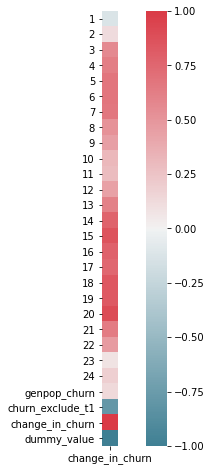

In [175]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

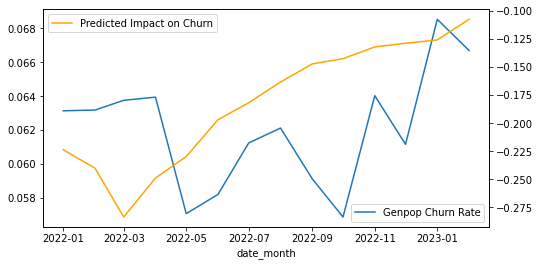

In [176]:
fig, ax = plt.subplots(figsize=(8, 4))

plot_df = churn_all
plot_df['date_month'] = pd.to_datetime(plot_df['date_month'])
ax.plot(plot_df['date_month'], plot_df['genpop_churn'], label= 'Genpop Churn Rate')

ax2 = ax.twinx()
ax2.plot(plot_df['date_month'], plot_df['change_in_churn'], label= 'Predicted Impact on Churn', color = 'orange')

ax.set_xlabel('date_month')
ax.legend(loc = 'lower right')
ax2.legend(loc = 'upper left')

plt.show()

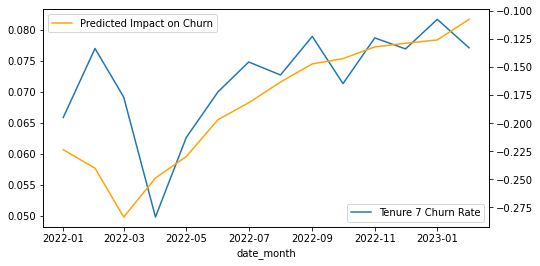

In [177]:
fig, ax = plt.subplots(figsize=(8, 4))

plot_df = churn_all
plot_df['date_month'] = pd.to_datetime(plot_df['date_month'])
ax.plot(plot_df['date_month'], plot_df[7], label= 'Tenure 7 Churn Rate')

ax2 = ax.twinx()
ax2.plot(plot_df['date_month'], plot_df['change_in_churn'], label= 'Predicted Impact on Churn', color = 'orange')

ax.set_xlabel('date_month')
ax.legend(loc = 'lower right')
ax2.legend(loc = 'upper left')

plt.show()

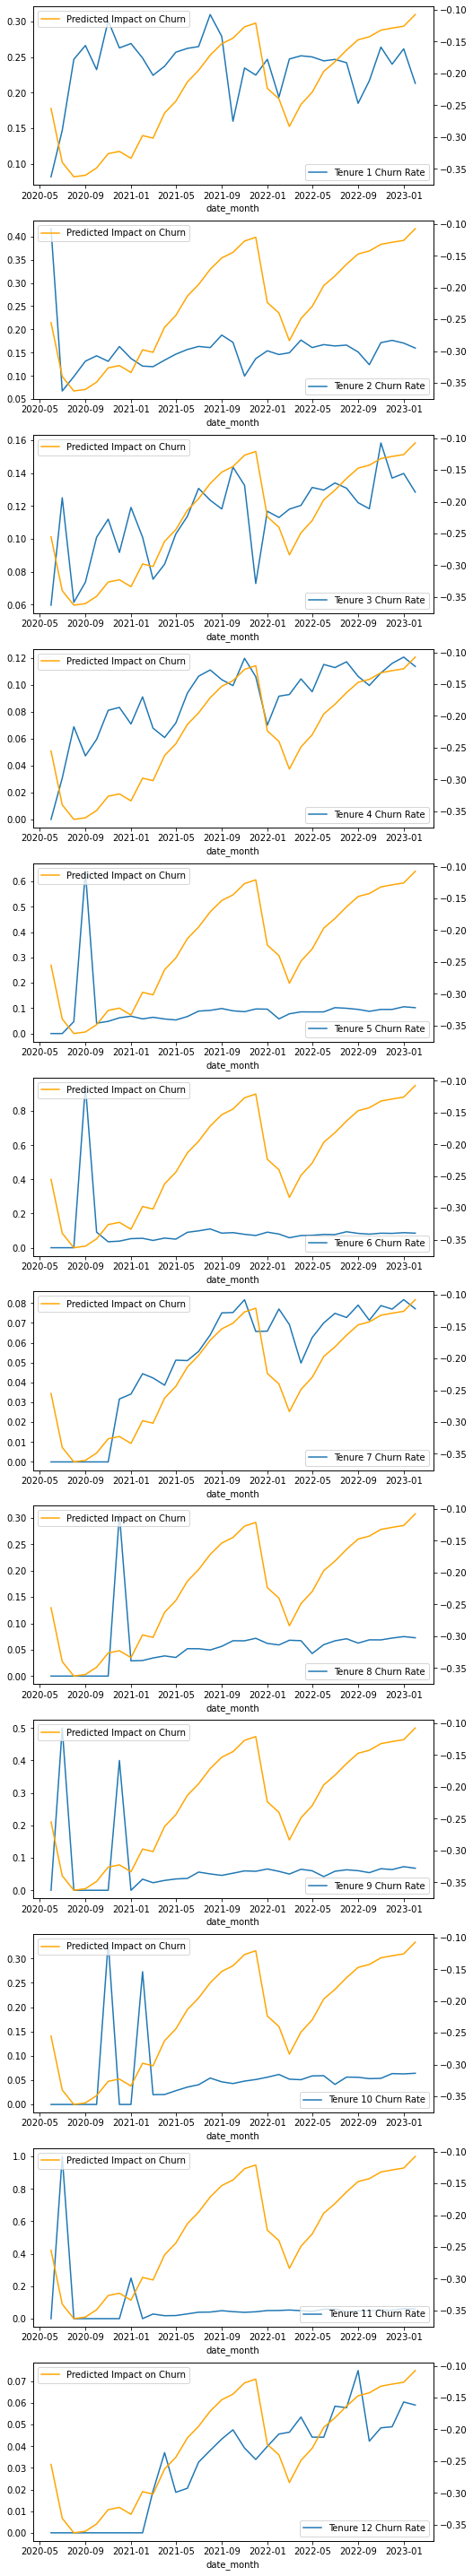

In [96]:
# fig, ax = plt.subplots(figsize=(8, 4))
plot_df = churn_all
plot_df['date_month'] = pd.to_datetime(plot_df['date_month'])
fig, ax = plt.subplots(12,1,figsize=(8, 52))

for i in range(0, 12, 1):
    ax1 = ax[i]
    ax1.plot(plot_df['date_month'], plot_df[i+1], label= 'Tenure ' + str(i+1)+ ' Churn Rate')

    ax2 = ax[i].twinx()
    ax2.plot(plot_df['date_month'], plot_df['change_in_churn'], label= 'Predicted Impact on Churn', color = 'orange')

    ax1.set_xlabel('date_month')
    ax1.legend(loc = 'lower right')
    ax2.legend(loc = 'upper left')

plt.show()
    

## 2. Correlation with Churn changes

In [76]:
churn_genpop_tenure_bucekts = run_query('''
select
     dt.start_date as date_month, 
     case when sub_month <=3 then '1-3'
          when sub_month <=6 then '4-6'
          when sub_month <=12 then '7-12'
          when sub_month <=24 then '13-24'
          else '24+'
     end as tenure,
    COUNT(DISTINCT CASE WHEN is_cancel = TRUE THEN up.hbo_uuid ELSE NULL END) as churns,
    COUNT(DISTINCT up.hbo_uuid) as total_subs,
    churns/total_subs as churn_rate
from MAX_PROD.CONTENT_ANALYTICS.CALENDAR_DATE_TRACKER dt
JOIN max_prod.identity.user_profile_dim_current up 
JOIN max_dev.workspace.user_retain_churn_list_test as c 
    on c.hurley_user_id = up.hurley_user_id
    and c.cycle_expire_date BETWEEN START_DATE and END_DATE
WHERE 1=1
AND up.is_primary_profile=1
AND dt.end_date = DATEADD('DAY', -1, (DATEADD('MONTH', 1, dt.start_date)))
AND dt.start_date = DATE_TRUNC('MONTH', dt.start_date)
and dt.start_date < '2023-03-01'
and SUB_MONTH <=24
group by 1, 2
order by 1, 2
''')

In [178]:
churn_genpop_tenure_bucekts_pivot = pd.pivot_table(churn_genpop_tenure_bucekts, values='churn_rate', index=['date_month'],
                       columns=['tenure'], fill_value=0, aggfunc='first').reset_index()

In [179]:
aggregated_churn = data.groupby(['date_month'])['change_in_churn'].sum().reset_index()
aggregated_churn['date_month'] = aggregated_churn['date_month'].dt.to_timestamp().dt.strftime('%Y-%m-%d')

### GENPOP ONLY LOOKS AT 2022-01-01 ON-WARDS ###################################
aggregated_churn = aggregated_churn[aggregated_churn['date_month']>='2022-01-01']

In [180]:
churn_bucekts_all = churn_genpop_tenure_bucekts_pivot.merge(churn_genpop[['date_month', 'churn_rate']].rename(columns = {'churn_rate':'genpop_churn'}),
                                           on = ['date_month'])\
                                    .merge(churn_exclude_t1[['date_month', 'churn_rate']].rename(columns = {'churn_rate':'churn_exclude_t1'}),
                                          on = ['date_month'])

In [181]:
churn_bucekts_all['date_month'] = churn_bucekts_all['date_month'].astype(str)

In [182]:
churn_bucekts_all = churn_bucekts_all.merge(aggregated_churn, on = ['date_month'])

In [183]:
churn_bucekts_all.head()

date_month       1-3     13-24       4-6      7-12 genpop_churn  \
0  2022-01-01  0.191762  0.027711  0.081849  0.057722     0.063140   
1  2022-02-01  0.164485  0.031045  0.072944  0.058322     0.063184   
2  2022-03-01  0.170197  0.027813  0.072797  0.054829     0.063757   
3  2022-04-01  0.172488  0.029994  0.090079  0.054364     0.063942   
4  2022-05-01  0.188415  0.030916  0.087246  0.050639     0.057086   

  churn_exclude_t1  change_in_churn  
0         0.063128        -0.223622  
1         0.063168        -0.240078  
2         0.063743        -0.283556  
3         0.063927        -0.248842  
4         0.057072        -0.229743

In [184]:
TARGET_COL = ['change_in_churn']
FEATURE_COLS = ['1-3', '4-6', '7-12', '13-24', 'genpop_churn']

In [185]:
FEATURE_COLS

['1-3', '4-6', '7-12', '13-24', 'genpop_churn']

In [186]:
for i in FEATURE_COLS:
    churn_bucekts_all[i] = churn_bucekts_all[i].astype(float)

In [187]:
import matplotlib.pyplot as plt 
import seaborn as sns

In [188]:
plot_data=churn_bucekts_all[FEATURE_COLS+TARGET_COL]
corr = plot_data.corr()[TARGET_COL]
mask=np.zeros_like(corr, dtype=np.bool)
corr.loc['dummy_value'] = -1
# corr.sort_values(by = TARGET_COL)
# 0.819
corr

change_in_churn
1-3                     0.284506
4-6                     0.827904
7-12                    0.709157
13-24                   0.889571
genpop_churn            0.138631
change_in_churn         1.000000
dummy_value            -1.000000

<AxesSubplot:>

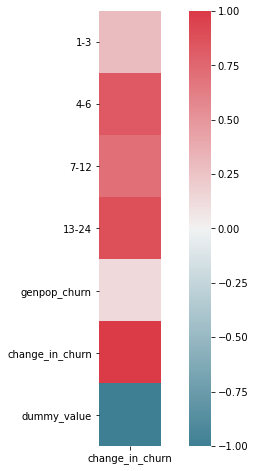

In [130]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

# Write to S3/SF

In [ ]:
from abc import ABCMeta, abstractmethod

class Credentials(metaclass=ABCMeta):
    pass
    
    
class SSMPSCredentials(Credentials):
    def __init__(self, secretid: str):
        self._secretid = secretid
        self._secrets = {}
        
    def get_keys(self):
        """
        credential fetching 
        """
        _aws_sm_args = {'service_name': 'secretsmanager', 'region_name': 'us-east-1'}
        secrets_client = boto3.client(**_aws_sm_args)
        get_secret_value_response = secrets_client.get_secret_value(SecretId=self._secretid)
        return get_secret_value_response
    
    
class BaseConnector(metaclass=ABCMeta):
    @abstractmethod
    def connect(self):
        raise NotImplementedError
    

class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )

        return ctx
    
## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
ctx=conn.connect("MAX_DEV","WORKSPACE")

def run_query(query):
    cursor = ctx.cursor()
    cursor.execute(query)
    df = pd.DataFrame(cursor.fetchall(), columns = [desc[0] for desc in cursor.description])
    df.columns= df.columns.str.lower()
    return df

In [ ]:
import boto3
import io

def to_s3(filename, output_bucket, content):
    client = boto3.client('s3')
    client.put_object(Bucket=output_bucket, Key=filename, Body=content)
    
output_bucket = 'hbo-outbound-datascience-content-dev'
s3 = boto3.resource('s3')
bucket = s3.Bucket(output_bucket)

def write_to_sf(df, file_name):
    csv_buffer = io.StringIO()
    df.to_csv(csv_buffer, index = False)
    content = csv_buffer.getvalue()
    filename = 'title_hours_viewed_retention/{}.csv'.format(file_name)
    to_s3(filename, output_bucket, content)

In [ ]:
write_to_sf(data, 'daily_monthly_retention_value.csv')

In [273]:
output_bucket+'/title_hours_viewed_retention/{}.csv'.format('daily_monthly_retention_value')

'hbo-outbound-datascience-content-dev/title_hours_viewed_retention/daily_monthly_retention_value.csv'